
Null values in dataset:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Processed features:
['Pclass', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Age', 'Fare', 'SibSp', 'Parch']


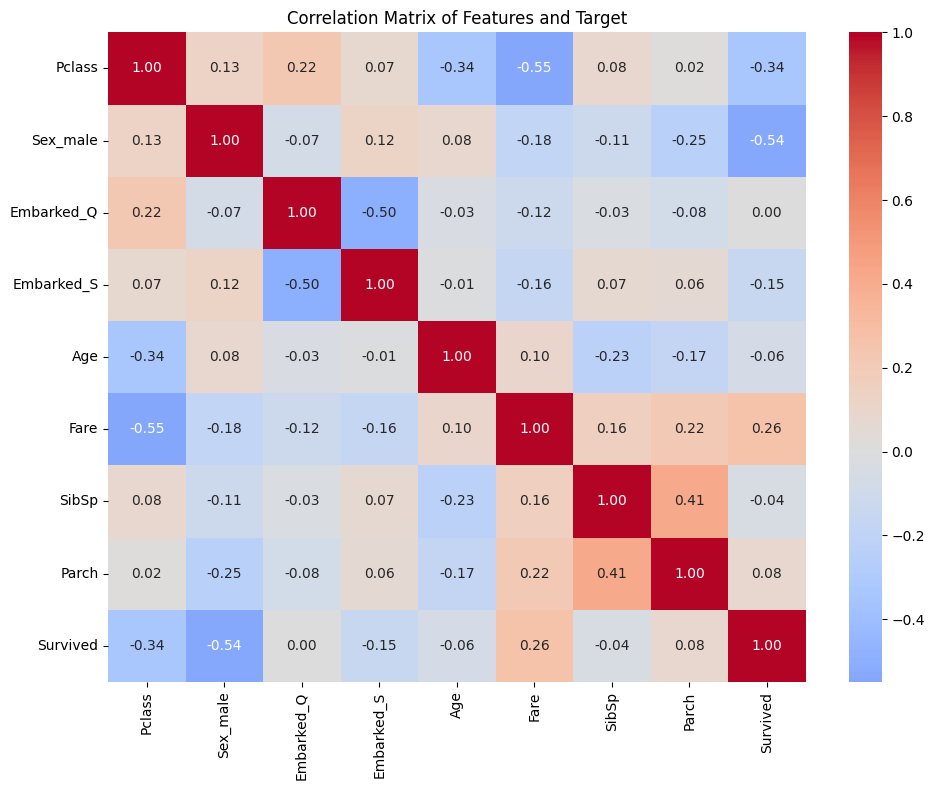


Feature correlations with Survived:
Sex_male: 0.543
Pclass: 0.338
Fare: 0.257
Embarked_S: 0.150
Parch: 0.082
Age: 0.065
SibSp: 0.035
Embarked_Q: 0.004

Selected features (correlation > 0.1):
['Sex_male', 'Pclass', 'Fare', 'Embarked_S']
Training set shape: (713, 4), Testing set shape: (178, 4)


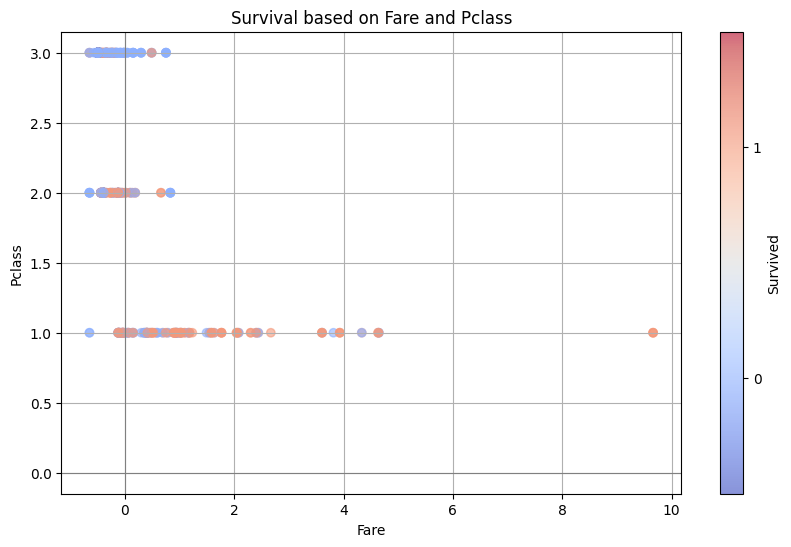

Iteration    0: Cost 0.6905
Iteration 10000: Cost 0.4749
Iteration 20000: Cost 0.4650
Iteration 30000: Cost 0.4627
Iteration 40000: Cost 0.4621
Iteration 50000: Cost 0.4620
Iteration 60000: Cost 0.4620
Iteration 70000: Cost 0.4619
Iteration 80000: Cost 0.4619
Iteration 90000: Cost 0.4619
Final cost after gradient descent: 0.4619


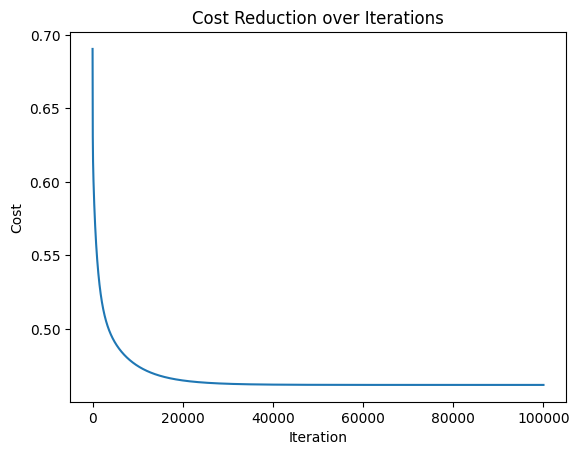

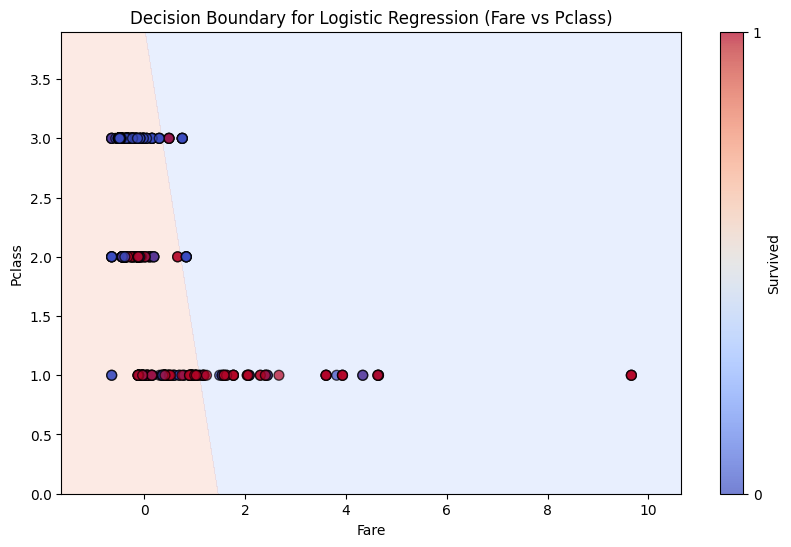

Train Accuracy: 77.279102
Train Precision: 69.597070
Train Recall: 70.631970
Train F1 Score: 70.110701
Test Accuracy: 79.213483
Test Precision: 71.428571
Test Recall: 82.191781
Test F1 Score: 76.433121


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

def preprocess_titanic_data(df):
    """
    Preprocessing of Titanic dataset
    """
    # Create a copy to avoid modifying original data
    data = df.copy()
    
    # Check null values
    print("\nNull values in dataset:")
    print(data.isnull().sum())
    
    # Handle missing values - using recommended pandas syntax
    data.loc[:, 'Age'] = data['Age'].fillna(data['Age'].median())
    data.loc[:, 'Fare'] = data['Fare'].fillna(data['Fare'].median())
    data.loc[:, 'Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
    
    # Extract target variable
    y = data['Survived']
    
    # Select features for processing
    features_to_encode = ['Sex', 'Embarked', 'Pclass']
    numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']
    
    # Create dummy variables for categorical features
    X = pd.get_dummies(data[features_to_encode], drop_first=True)
    
    # Add standardized numerical features
    for feature in numerical_features:
        X[feature] = (data[feature] - data[feature].mean()) / data[feature].std()
    
    return X, y

def analyze_features(X, y):
    """
    Analyze feature importance using correlation matrix
    """
    # Add target to features for correlation analysis
    data_corr = X.copy()
    data_corr['Survived'] = y
    
    # Calculate and display correlation matrix
    correlation_matrix = data_corr.corr()
    
    # Create correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation Matrix of Features and Target')
    plt.tight_layout()
    plt.show()
    
    # Get feature correlations with target
    target_correlations = abs(correlation_matrix['Survived']).sort_values(ascending=False)
    target_correlations = target_correlations.drop('Survived')
    
    print("\nFeature correlations with Survived:")
    for feature, corr in target_correlations.items():
        print(f"{feature}: {corr:.3f}")
    
    # Select features with correlation > 0.1
    selected_features = target_correlations[target_correlations > 0.1].index.tolist()
    
    print("\nSelected features (correlation > 0.1):")
    print(selected_features)
    
    return X[selected_features]

def split_data(X, y, test_size=0.2):
    """
    Split data into training and testing sets
    """
    # Calculate the number of samples
    num_samples = X.shape[0]
    num_test_samples = int(num_samples * test_size)
    
    # Create indices for shuffling
    indices = np.arange(num_samples)
    np.random.shuffle(indices)  # Shuffle the indices
    
    # Split indices for training and testing
    test_indices = indices[:num_test_samples]
    train_indices = indices[num_test_samples:]
    
    # Create training and testing sets
    X_train = X.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_train = y.iloc[train_indices]
    y_test = y.iloc[test_indices]
    
    return X_train, X_test, y_train, y_test

def plot_data(X, y, pos_label="Survived", neg_label="Not Survived"):
    """
    Visualize the relationship between features and target variable.
    """
    plt.figure(figsize=(10, 6))

    # Use 'Fare' and 'Pclass' for the plot
    plt.scatter(X['Fare'], X['Pclass'], c=y, cmap='coolwarm', alpha=0.6)

    plt.title('Survival based on Fare and Pclass')
    plt.xlabel('Fare')
    plt.ylabel('Pclass')
    plt.colorbar(ticks=[0, 1], label='Survived')
    plt.clim(-0.5, 1.5)  # Adjust color limits
    plt.axhline(0, color='grey', lw=0.8)  # Optional: Add a horizontal line at y=0
    plt.axvline(0, color='grey', lw=0.8)  # Optional: Add a vertical line at x=0
    plt.grid()
    plt.show()

# Load and process data
df = pd.read_csv('titanic.csv')

# Preprocess data
X_processed, y = preprocess_titanic_data(df)
print("\nProcessed features:")
print(X_processed.columns.tolist())

# Perform feature selection
X_selected = analyze_features(X_processed, y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = split_data(X_selected, y, test_size=0.2)
print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

plot_data(X_train, y_train[:], pos_label="Survived", neg_label="Not survived")

def sigmoid(z):
    z = np.array(z, dtype=float)  # Ensures `z` is a numpy array with float type
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, w, b, lambda_=0): 
    m = len(y)
    z = np.dot(X, w) + b
    f_wb = sigmoid(z)
    cost = -np.mean(y * np.log(f_wb + 1e-10) + (1 - y) * np.log(1 - f_wb + 1e-10))  # Avoid log(0)
    return cost + (lambda_ / (2 * m)) * np.sum(w ** 2)  # Regularization term

def compute_gradient(X, y, w, b, lambda_=0): 
    m, n = X.shape
    f_wb = sigmoid(np.dot(X, w) + b)
    error = f_wb - y
    
    dj_dw = (1 / m) * np.dot(X.T, error) + (lambda_ / m) * w  # Regularized gradient
    dj_db = np.mean(error)
    
    return dj_db, dj_dw

def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_):
    # Ensure inputs are numpy arrays of type float
    X = np.array(X, dtype=float)
    y = np.array(y, dtype=float)
    w = np.array(w_in, dtype=float)
    b = float(b_in)  # Make sure b is a float

    J_history = []
    w_history = []

    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w, b, lambda_)
        
        # Ensure gradient outputs are floats
        dj_dw = np.array(dj_dw, dtype=float)
        dj_db = float(dj_db)
        
        # Update parameters using learning rate (alpha)
        w -= alpha * dj_dw
        b -= alpha * dj_db
        
        # Save cost J at each iteration for monitoring
        cost = cost_function(X, y, w, b, lambda_)
        J_history.append(cost)

        # Print cost every 10% of iterations
        if i % max(1, num_iters // 10) == 0:
            w_history.append(w.copy())
            print(f"Iteration {i:4}: Cost {cost:.4f}")

    return w, b, J_history, w_history


# Initialize weights and bias
initial_w = np.zeros((X_train.shape[1],))  # Make sure it has the same number of columns as X_train
initial_b = 0.

# Set gradient descent parameters
iterations = 100000
alpha = 0.01

# Run gradient descent
w, b, J_history, _ = gradient_descent(np.array(X_train), np.array(y_train), initial_w, initial_b, compute_cost, compute_gradient, alpha, iterations, lambda_=0)


print(f"Final cost after gradient descent: {J_history[-1]:.4f}")

plt.plot(J_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost Reduction over Iterations")
plt.show()

def plot_decision_boundary(X, y, w, b, feature1='Fare', feature2='Pclass'):
    # Create a grid of values for plotting
    x_min, x_max = X[feature1].min() - 1, X[feature1].max() + 1
    y_min, y_max = X[feature2].min() - 1, X[feature2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
    # Flatten the grid and calculate the model's predictions
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_data = pd.DataFrame(grid, columns=[feature1, feature2])

    # Add other standardized features with mean zero (if using more than two features in your model)
    for col in X.columns:
        if col != feature1 and col != feature2:
            grid_data[col] = 0

    # Get predictions for the grid points
    probs = sigmoid(np.dot(grid_data, w) + b)
    Z = probs.reshape(xx.shape)
    
    # Plot decision boundary
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap='coolwarm', alpha=0.2)
    plt.scatter(X[feature1], X[feature2], c=y, cmap='coolwarm', edgecolor='k', s=50, alpha=0.7)
    
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.colorbar(ticks=[0, 1], label='Survived')
    plt.title(f'Decision Boundary for Logistic Regression ({feature1} vs {feature2})')
    plt.show()

# Call the plot_decision_boundary function with your trained weights and bias
plot_decision_boundary(X_train, y_train, w, b, feature1='Fare', feature2='Pclass')

def predict(X, w, b): 
    # Calculate the linear combination of inputs and weights plus bias
    z_wb = np.dot(X, w) + b
    
    # Apply the sigmoid function to get probabilities
    f_wb = sigmoid(z_wb)
    
    # Apply the threshold to get binary predictions
    p = (f_wb > 0.5).astype(int)  # Convert boolean to int (0 or 1)
    
    return p

def calculate_precision(y_true, y_pred):
    """
    Calculate precision
    """
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    false_positives = np.sum((y_true == 0) & (y_pred == 1))
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    return precision

def calculate_recall(y_true, y_pred):
    """
    Calculate recall
    """
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    false_negatives = np.sum((y_true == 1) & (y_pred == 0))
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    return recall

def calculate_f1_score(y_true, y_pred):
    """
    Calculate F1 Score
    """
    precision = calculate_precision(y_true, y_pred)
    recall = calculate_recall(y_true, y_pred)
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score

# After making predictions on the training and test sets, add these lines to calculate precision, recall, and F1 score

# Make predictions on the training set
p_train = predict(X_train, w, b)
print('Train Accuracy: %f' % (np.mean(p_train == y_train) * 100))

# Calculate metrics for the training set
train_precision = calculate_precision(y_train, p_train)
train_recall = calculate_recall(y_train, p_train)
train_f1_score = calculate_f1_score(y_train, p_train)

print('Train Precision: %f' % (train_precision * 100))
print('Train Recall: %f' % (train_recall * 100))
print('Train F1 Score: %f' % (train_f1_score * 100))

# Make predictions on the test set
p_test = predict(X_test, w, b)
print('Test Accuracy: %f' % (np.mean(p_test == y_test) * 100))

# Calculate metrics for the test set
test_precision = calculate_precision(y_test, p_test)
test_recall = calculate_recall(y_test, p_test)
test_f1_score = calculate_f1_score(y_test, p_test)

print('Test Precision: %f' % (test_precision * 100))
print('Test Recall: %f' % (test_recall * 100))
print('Test F1 Score: %f' % (test_f1_score * 100))





